In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [55]:
class Perceptron:
    def __init__(self, n_feature = 1, epoch = 200, lr = 0.01, tol = None):
        self.n_feature = n_feature
        self.epoch = epoch
        self.lr = lr
        self.tol = tol
        self.W = np.random.rand(n_feature + 1) * 0.5
        self.loss = []
        self.best_loss = np.inf
        self.patience = 10 
        self.X_train_bar = []

    def _loss(self, y, y_pred):
        return -y_pred * y if y_pred * y <0 else 0
    
    def _gradient(self, x_bar, y, y_pred):
        return -y * x_bar if y_pred * y <0 else 0
    
    def _preprocess_data(self,X):
        m, n = X.shape
        X_ = np.empty([m, n+1])
        X_[:, 0] = 1
        X_[:, 1:] = X
        return X_
    
    def sgd_update(self, X, y):
        break_out = False
        epoch_no_improve = 0

        for iter in range(self.epoch):
            for i,x in enumerate(X):
                y_pred = self._predict(x)
                loss = self._loss(y[i], y_pred)
                self.loss.append(loss)

                if self.tol is not None:
                    if loss < self.best_loss - self.tol:
                        self.best_loss = loss
                        epoch_no_improve = 0
                    elif np.abs(loss-self.best_loss) < self.tol:
                        epoch_no_improve += 1
                        if epoch_no_improve >= self.patience:
                            print(f"Early stopping triggered due to the no improvement in loss")
                            break_out = True
                            break
                        else:
                            epoch_no_improve = 0
                            grad = self._gradient(x, y[i], y_pred)
                            self.W -= self.lr * grad
                if break_out:
                    break_out = False
                    break


    def _sgd_update(self, X, y): #epoch=2750
        pred = X @ self.W 
        i = np.random.randint(0, len(X))
        grad = self._gradient(X[i,:][np.newaxis, :], y[i], pred[i])
        self.W -= self.lr * grad  # 随机梯度下降更新

    def _bgd_update(self, X, y): #lr=1e-6
        pred = X @ self.W 
        grad = self._gradient(X, y, pred)
        self.W -= self.lr * grad  # 批量梯度下降更新
        
    def _mbgd_update(self, X, y): #epoch=10000
        pred = self._predict(X)
        indices = np.random.choice(y.shape[0], self.batch_size, replace=False)
        grad = self._gradient(X[indices], y[indices], pred[indices])
        self.W -= self.lr * grad/self.batch_size

    def _predict(self, X):
        return X @ self.W
    
    def train(self, X_train, t_train):
        X_train_bar = self._preprocess_data(X_train)
        self.X_train_bar = X_train_bar
        print(X_train_bar,X_train_bar.shape)
        self.sgd_update(X_train_bar, t_train)
        print(self.W,self.W.shape)

    def plot_loss(self):
        plt.plot(self.loss)
        plt.grid()
        plt.show()

例子

In [56]:
# X_train = np.array([[-2,4],[4,1],[1,6],[2,4],[6,2]])
# y_train = np.array([-1,-1,1,1,1])
# _,n_feature = X_train.shape
# model = Perceptron(n_feature=n_feature, epoch = 200, lr = 0.01, tol = 1e-3)
# model.train(X_train,y_train)
# print(f"Learned weights are {model.W}")
# y_pred = np.sign(model._predict(model._preprocess_data(X_train)))
# print(f"Prediced labels are {y_pred}")

# plt.figure()
# model.plot_loss()

从wine.data中删除一类样本，并将保留后的两类样本wine_data_filtered作为新的数据集，并以（0.7，0.3）的比例将wine_data_filtered分为training set和test set

In [57]:
file_name = 'wine.data'

# 读取数据集
column_names = ['class_label'] + [f'feature_{i}' for i in range(13)]  
wine_data = pd.read_csv(file_name, header=None, names=column_names)

# 显示原始数据集的类别分布
print("Original dataset class distribution:")
print(wine_data['class_label'].value_counts())

# 删除 class_label = 1 的所有行
wine_data_filtered = wine_data[wine_data['class_label'] != 1]

# 显示新数据集的类别分布
print("\nNew dataset class distribution:")
print(wine_data_filtered['class_label'].value_counts())

# 检查新数据集的形状
print("\nOriginal dataset shape:", wine_data.shape)
print("New dataset shape:", wine_data_filtered.shape)

# 将数据分为特征和标签
X = wine_data_filtered.drop('class_label', axis=1).values
y = wine_data_filtered['class_label'].values

# 划分训练集和测试集，这里我们按照70%训练集，30%测试集的比例来划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 打印结果以确认划分
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Original dataset class distribution:
class_label
2    71
1    59
3    48
Name: count, dtype: int64

New dataset class distribution:
class_label
2    71
3    48
Name: count, dtype: int64

Original dataset shape: (178, 14)
New dataset shape: (119, 14)
Training set shape: (83, 13)
Test set shape: (36, 13)


[[1.000e+00 1.156e+01 2.050e+00 ... 9.300e-01 3.690e+00 4.650e+02]
 [1.000e+00 1.288e+01 2.990e+00 ... 7.400e-01 1.420e+00 5.300e+02]
 [1.000e+00 1.334e+01 9.400e-01 ... 1.020e+00 1.930e+00 7.500e+02]
 ...
 [1.000e+00 1.279e+01 2.670e+00 ... 4.800e-01 1.470e+00 4.800e+02]
 [1.000e+00 1.146e+01 3.740e+00 ... 7.500e-01 2.810e+00 5.620e+02]
 [1.000e+00 1.369e+01 3.260e+00 ... 9.600e-01 1.820e+00 6.800e+02]] (83, 14)
[0.274198   0.02478604 0.14223267 0.26355985 0.10623811 0.46264539
 0.05351522 0.34587228 0.47592059 0.15589975 0.11943345 0.17453396
 0.31608532 0.33624033] (14,)
Learned weights are [0.274198   0.02478604 0.14223267 0.26355985 0.10623811 0.46264539
 0.05351522 0.34587228 0.47592059 0.15589975 0.11943345 0.17453396
 0.31608532 0.33624033]
Prediced labels are [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

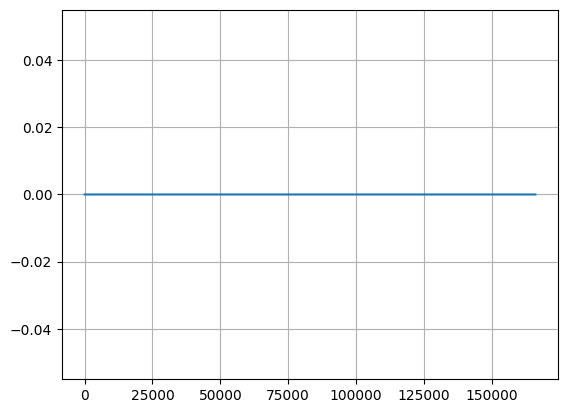

In [58]:
model = Perceptron(n_feature = X_train.shape[1], epoch = 2000, lr = 1, tol = 1e-3)
model.train(X_train,y_train)
print(f"Learned weights are {model.W}")
y_pred = np.sign(model._predict(model.X_train_bar))

# y_pred = np.sign(model._predict(model._preprocess_data(X_train)))
print(f"Prediced labels are {y_pred}")

plt.figure()
model.plot_loss()

In [59]:
y_pred = np.argmax(model._predict(model._preprocess_data(X_test)), axis=1)

# 计算多分类问题的指标
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro Recall: {recall}")
print(f"Macro Precision: {precision}")
print(f"Macro F1 Score: {f1}")

# 计算 Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 计算 Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# 计算 Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# 计算 F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

AxisError: axis 1 is out of bounds for array of dimension 1